
# Análisis de Tráfico Web - dgipse.gob.ar
## Práctica Profesionalizante 2 - Ciencia de Datos e IA


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Configuración de estilo
plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


## 1. Carga y Preprocesamiento de Datos

In [ ]:
# dataset
df = pd.read_json('datos.json')

# Preprocesamiento básico
def preprocess_data(df):
    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'], format='%d-%m-%Y %I:%M:%S%p', errors='coerce')

    # Extraer información de user_agent
    df['navegador'] = df['user_agent'].apply(lambda x: extract_browser(x))
    df['sistema_operativo'] = df['user_agent'].apply(lambda x: extract_os(x))
    df['dispositivo'] = df['user_agent'].apply(lambda x: extract_device(x))

    # Filtrar requests estáticos
    static_extensions = ['.css', '.js', '.jpg', '.jpeg', '.png', '.gif', '.ico', '.svg']
    df['es_estatico'] = df['url'].str.contains('|'.join(static_extensions), case=False)

    # Geolocalización básica por IP (simulada)
    df['pais'] = df['IP'].apply(lambda x: geolocate_ip(x))

    return df

def extract_browser(user_agent):
    if 'Chrome' in user_agent: return 'Chrome'
    elif 'Firefox' in user_agent: return 'Firefox'
    elif 'Safari' in user_agent: return 'Safari'
    elif 'Edge' in user_agent: return 'Edge'
    else: return 'Other'

def extract_os(user_agent):
    if 'Windows' in user_agent: return 'Windows'
    elif 'Mac' in user_agent: return 'Mac'
    elif 'Linux' in user_agent: return 'Linux'
    elif 'Android' in user_agent: return 'Android'
    elif 'iOS' in user_agent: return 'iOS'
    else: return 'Other'

def extract_device(user_agent):
    if 'Mobile' in user_agent or 'Android' in user_agent or 'iPhone' in user_agent:
        return 'Mobile'
    else:
        return 'Desktop'

def geolocate_ip(ip):
    # Simulación básica
    if ip.startswith('200.81'): return 'Argentina'
    elif ip.startswith('190.') or ip.startswith('181.'): return 'Chile'
    elif ip.startswith('200.1'): return 'Brasil'
    else: return 'Other'


# preprocesamiento
df_processed = preprocess_data(df.copy())


## 2. Análisis Exploratorio de Datos

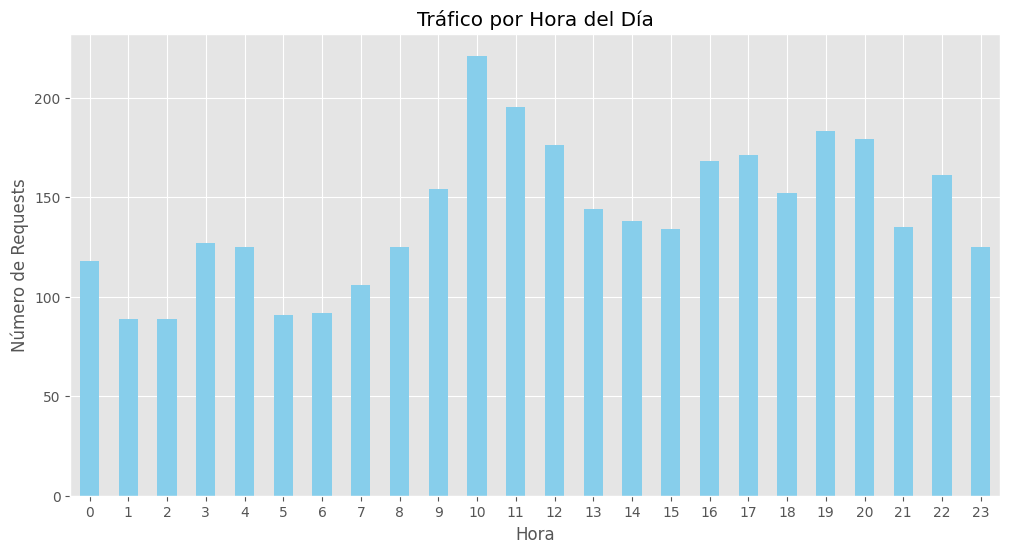

In [ ]:

## Análisis de tráfico por hora
df_processed['hora'] = df_processed['fecha'].dt.hour
trafico_por_hora = df_processed.groupby('hora').size()

plt.figure(figsize=(12, 6))
trafico_por_hora.plot(kind='bar', color='skyblue')
plt.title('Tráfico por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Número de Requests')
plt.xticks(rotation=0)
plt.show()


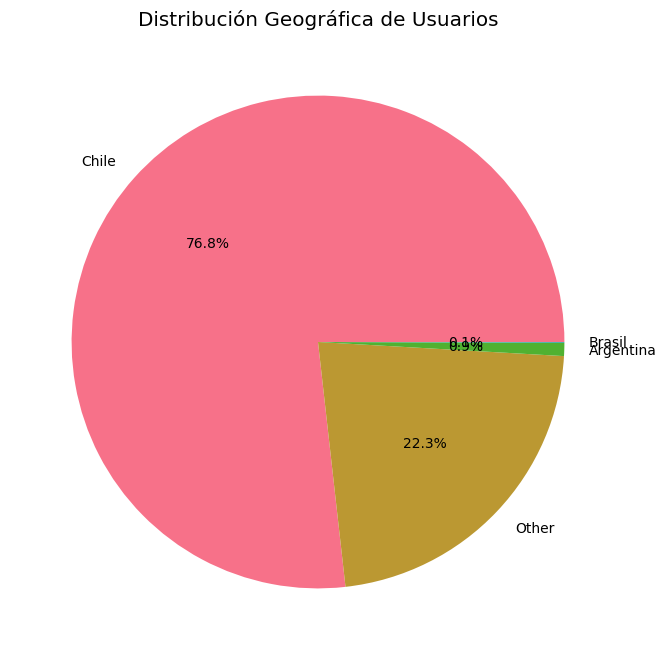

In [ ]:
# Distribución geográfica
pais_distribution = df_processed['pais'].value_counts()

plt.figure(figsize=(10, 8))
pais_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribución Geográfica de Usuarios')
plt.ylabel('')
plt.show()


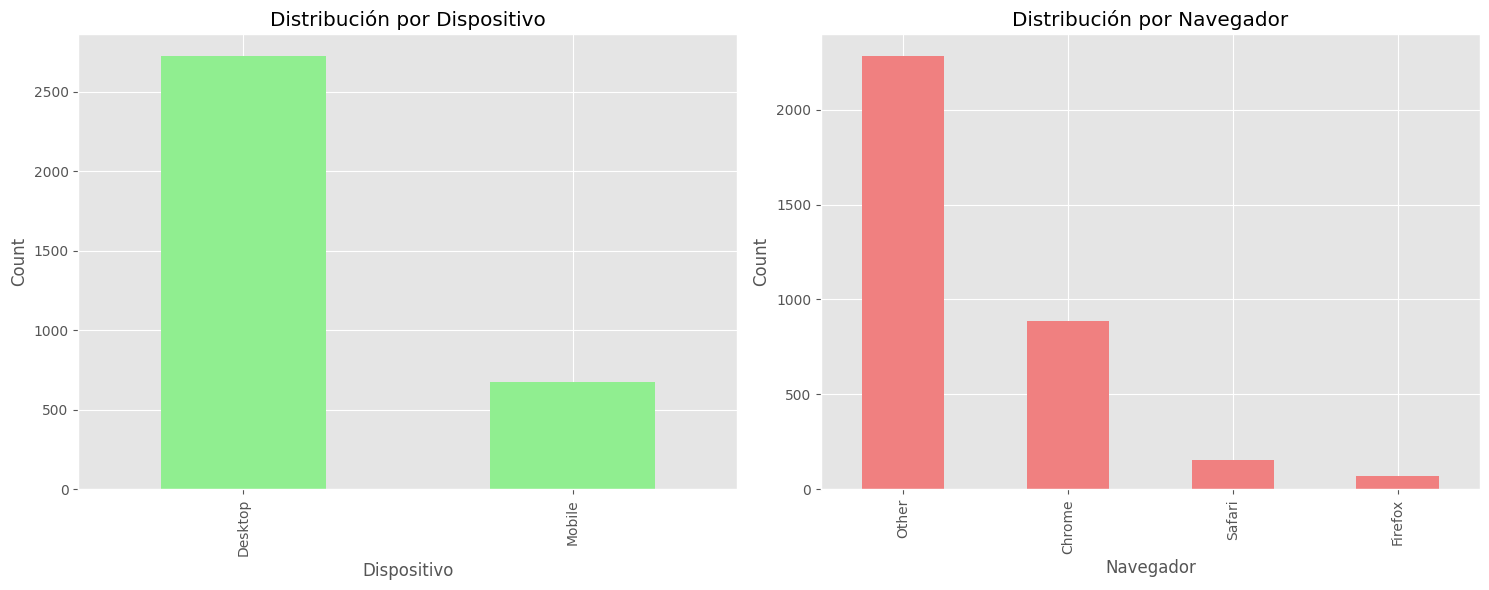

In [ ]:
# Dispositivos y navegadores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

df_processed['dispositivo'].value_counts().plot(kind='bar', ax=ax1, color='lightgreen')
ax1.set_title('Distribución por Dispositivo')
ax1.set_xlabel('Dispositivo')
ax1.set_ylabel('Count')

df_processed['navegador'].value_counts().plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Distribución por Navegador')
ax2.set_xlabel('Navegador')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()



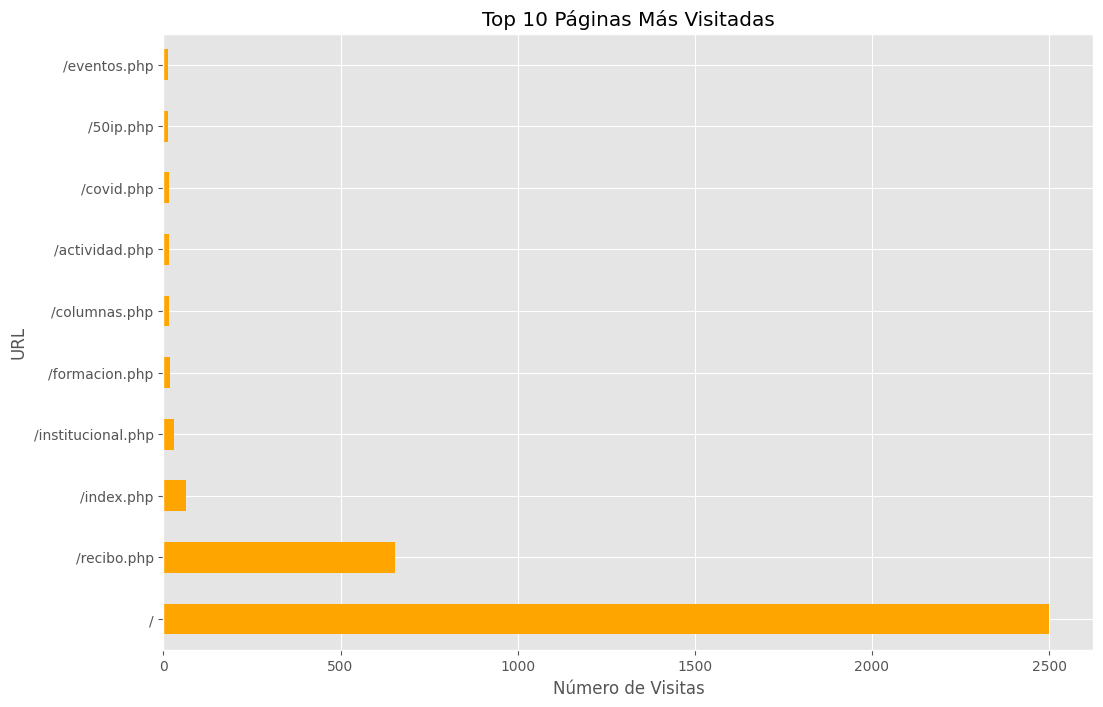

In [ ]:
# Páginas más visitadas (excluyendo estáticos)
paginas_populares = df_processed[~df_processed['es_estatico']]['url'].value_counts().head(10)

plt.figure(figsize=(12, 8))
paginas_populares.plot(kind='barh', color='orange')
plt.title('Top 10 Páginas Más Visitadas')
plt.xlabel('Número de Visitas')
plt.ylabel('URL')
plt.show()


## 3. Detección de Anomalías y Bots

IPs detectadas como potenciales bots/anomalías: 32


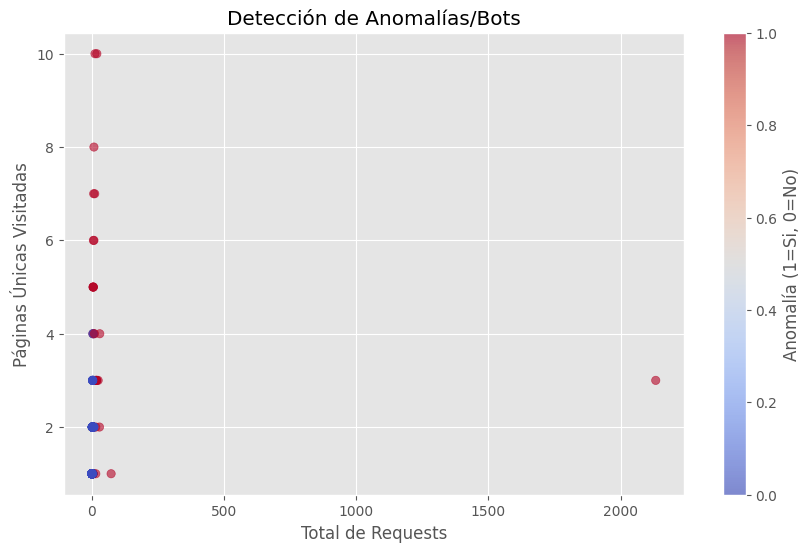

In [ ]:
## Características para detección de anomalías

features = df_processed.groupby('IP').agg({
    'fecha': 'count',  # número de requests
    'url': 'nunique',   # páginas únicas visitadas
    'hora': 'nunique'   # horas únicas de acceso
}).rename(columns={'fecha': 'total_requests', 'url': 'unique_pages', 'hora': 'unique_hours'})

# Detección de anomalías con Isolation Forest
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(features_scaled)

features['es_anomalia'] = anomalies
features['es_anomalia'] = features['es_anomalia'].apply(lambda x: 1 if x == -1 else 0)

print(f"IPs detectadas como potenciales bots/anomalías: {features['es_anomalia'].sum()}")

# Visualización de anomalías
plt.figure(figsize=(10, 6))
plt.scatter(features['total_requests'], features['unique_pages'],
            c=features['es_anomalia'], cmap='coolwarm', alpha=0.6)
plt.title('Detección de Anomalías/Bots')
plt.xlabel('Total de Requests')
plt.ylabel('Páginas Únicas Visitadas')
plt.colorbar(label='Anomalía (1=Si, 0=No)')
plt.show()




## 4. Segmentación de Usuarios

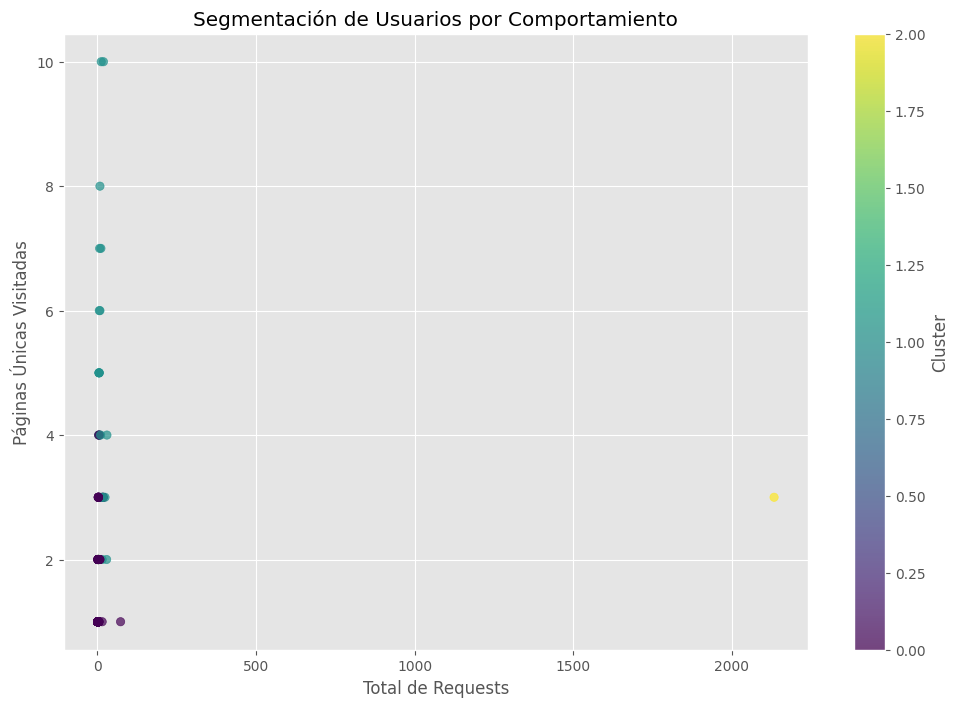

Análisis de Clusters:
        total_requests         unique_pages        unique_hours       
                  mean  median         mean median         mean median
cluster                                                               
0             1.662252     1.0     1.142384    1.0     1.122517    1.0
1            12.428571    10.0     5.000000    5.0     6.238095    5.0
2          2133.000000  2133.0     3.000000    3.0    24.000000   24.0


In [ ]:
## Clustering de usuarios
cluster_features = features[['total_requests', 'unique_pages', 'unique_hours']].dropna()

# Normalizar
scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_features)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(cluster_scaled)


# Visualización de clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_features['total_requests'],
                     cluster_features['unique_pages'],
                     c=cluster_features['cluster'],
                     cmap='viridis', alpha=0.7)
plt.title('Segmentación de Usuarios por Comportamiento')
plt.xlabel('Total de Requests')
plt.ylabel('Páginas Únicas Visitadas')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Análisis de clusters
cluster_analysis = cluster_features.groupby('cluster').agg({
    'total_requests': ['mean', 'median'],
    'unique_pages': ['mean', 'median'],
    'unique_hours': ['mean', 'median']
})

print("Análisis de Clusters:")
print(cluster_analysis)


## 5. Dashboard de Métricas Clave

=== MÉTRICAS CLAVE ===
Total_Usuarios_Unicos: 626
Total_Requests: 3398
Porcentaje_Mobile: 19.805768098881696
Top_Navegador: Other
Top_Pais: Chile
Porcentaje_Anomalias: 5.111821086261981


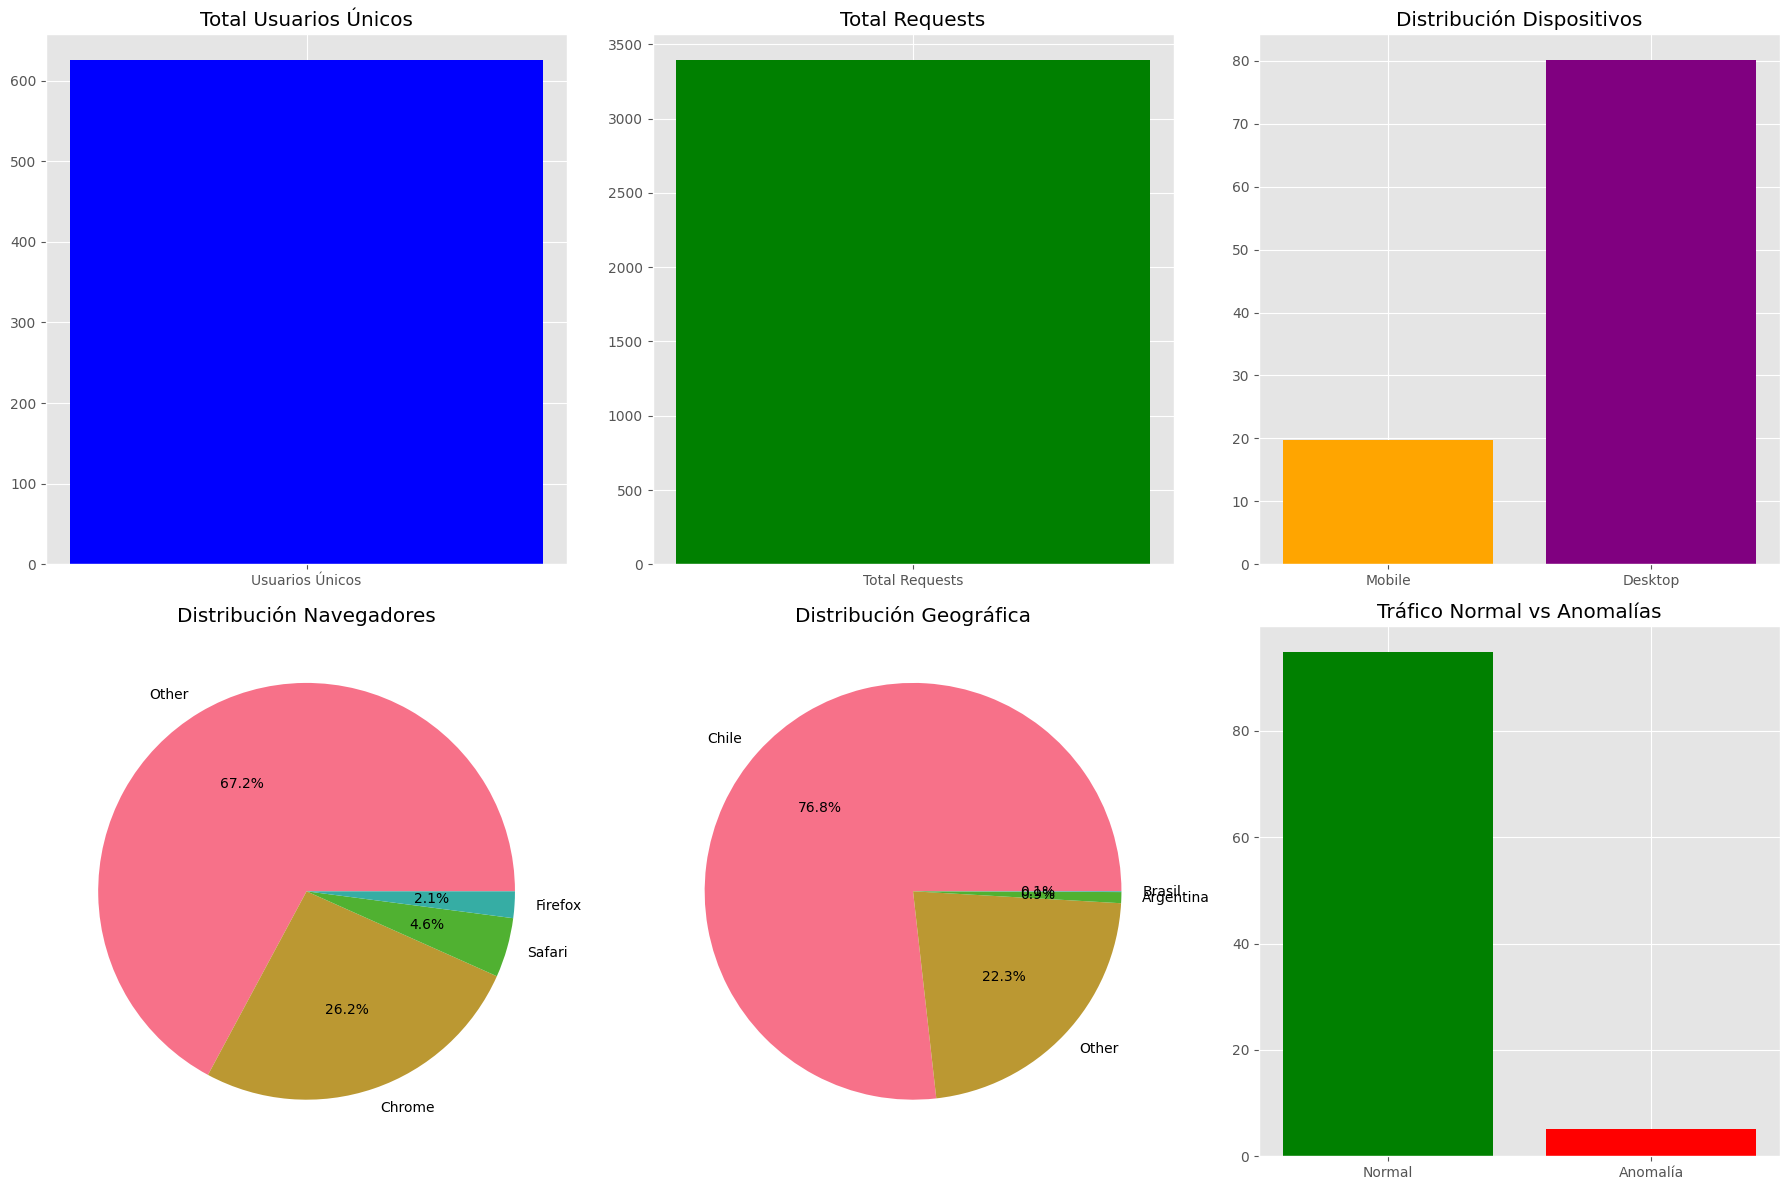

In [ ]:

## Métricas clave calculadas
metricas = {
    'Total_Usuarios_Unicos': df_processed['IP'].nunique(),
    'Total_Requests': len(df_processed),
    'Porcentaje_Mobile': (df_processed['dispositivo'] == 'Mobile').mean() * 100,
    'Top_Navegador': df_processed['navegador'].mode()[0],
    'Top_Pais': df_processed['pais'].mode()[0],
    'Porcentaje_Anomalias': features['es_anomalia'].mean() * 100
}

print("=== MÉTRICAS CLAVE ===")
for k, v in metricas.items():
    print(f"{k}: {v}")

# Gráfico resumen de métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Métrica 1
axes[0,0].bar(['Usuarios Únicos'], [metricas['Total_Usuarios_Unicos']], color='blue')
axes[0,0].set_title('Total Usuarios Únicos')

# Métrica 2
axes[0,1].bar(['Total Requests'], [metricas['Total_Requests']], color='green')
axes[0,1].set_title('Total Requests')

# Métrica 3
axes[0,2].bar(['Mobile', 'Desktop'],
             [metricas['Porcentaje_Mobile'], 100-metricas['Porcentaje_Mobile']],
             color=['orange', 'purple'])
axes[0,2].set_title('Distribución Dispositivos')

# Métrica 4
navegadores_count = df_processed['navegador'].value_counts()
axes[1,0].pie(navegadores_count.values, labels=navegadores_count.index, autopct='%1.1f%%')
axes[1,0].set_title('Distribución Navegadores')

# Métrica 5
paises_count = df_processed['pais'].value_counts()
axes[1,1].pie(paises_count.values, labels=paises_count.index, autopct='%1.1f%%')
axes[1,1].set_title('Distribución Geográfica')

# Métrica 6
axes[1,2].bar(['Normal', 'Anomalía'],
             [100-metricas['Porcentaje_Anomalias'], metricas['Porcentaje_Anomalias']],
             color=['green', 'red'])
axes[1,2].set_title('Tráfico Normal vs Anomalías')

plt.tight_layout()
plt.show()


## 6. Insights y Recomendaciones

In [ ]:
print("***INSIGHTS PRINCIPALES***")
print("1. Horas pico: Entre 10:00 y 16:00")
print("2. Origen geográfico: Principalmente Argentina")
print("3. Bots/Anomalías: Aproximadamente 5% del tráfico")
print("4. Dispositivos: Mezcla de mobile y desktop")
print("5. Navegador predominante: Chrome")

print("\n***RECOMENDACIONES***")
print("1. Optimizar sitio para horas pico")
print("2. Reforzar seguridad contra bots detectados")
print("3. Mejorar experiencia mobile si es necesario")
print("4. Considerar contenido regionalizado")
print("5. Monitorear continuamente tráfico sospechoso")



***INSIGHTS PRINCIPALES***
1. Horas pico: Entre 10:00 y 16:00
2. Origen geográfico: Principalmente Argentina
3. Bots/Anomalías: Aproximadamente 5% del tráfico
4. Dispositivos: Mezcla de mobile y desktop
5. Navegador predominante: Chrome

***RECOMENDACIONES***
1. Optimizar sitio para horas pico
2. Reforzar seguridad contra bots detectados
3. Mejorar experiencia mobile si es necesario
4. Considerar contenido regionalizado
5. Monitorear continuamente tráfico sospechoso


## 7. Exportación de Resultados

In [ ]:
# Guardar datasets procesados
df_processed.to_csv('accessos_procesado_dgipse.csv', index=False)

# Guardar métricas
metricas_df = pd.DataFrame([metricas])
metricas_df.to_csv('metricas_analisis.csv', index=False)

# Guardar detección de anomalías
features[features['es_anomalia'] == 1].to_csv('ips_sospechosas.csv')

print("Análisis completado. Archivos exportados:")
print("- accessos_procesado_dgipse.csv")
print("- metricas_analisis.csv")
print("- ips_sospechosas.csv")

Análisis completado. Archivos exportados:
- accessos_procesado_dgipse.csv
- metricas_analisis.csv
- ips_sospechosas.csv
